# Design Considerations

## Part 1: Identify FIVE design decisions for this system.
Argue for how this design decision is significant to the system, and your plans to analyze this design. If needed, use the dataset provided to you.

### 1. Sentences per Chunk
One important factor to consider is the number of sentences per chunk, which is used by the `DocumentProcessing` class to split the corpus documents into smaller chunks before the pipeline calculates the embedding vector for each chunk. During the retrieval and generation process, these chunks will be used as context and provided as input to the generator LLM that generates the answer to the question. Therefore, the number of sentences in these chunks will directly affect how much contextual information the generator will have available to generate a response. A high number of sentences per chunk provides the generator with lots of contextual information, which might be useful for complex questions. However, too much information may result in irrelevant information being provided to the generator, which may confuse the model and produce unreliable answers. A small number of sentences per chunk could decrease the chances of providing irrelevant information, but could also decrease the chances of including the true answer in the context.

**Analysis Plan**

To analyze the effects of different numbers of sentences per chunk, a validation set of questions, like the ones in [qa_resources/questions.csv](../qa_resources/questions.csv), could be used to test how the RAG system performs when the corpus documents have been processed using different numbers of sentences per chunk. For example we could use sentence per chunk values of [1,2,3,4,5,6] and for each value, we can calculate the document embeddings using the specified sentences per chunk, and use those embeddings to retrieve the context to be used to generate an answer for each question in the validation set. The answers to each question can be evaluated using automated metrics such as exact match and transformer match metrics. Additionally, the time it takes to get the context and generate an answer for a question can be tracked to identify any potential differences in latency for different sentences per chunk values. The sentences per chunk value that results in the best balance of high transformer match and low latency would be chosen for deployment to the system. Transformer match metric is prioritized over exact match because it allows for some flexibility in phrasing, paraphrasing, or use of synonyms in the generated response.

### 2. Similarity Measure
Another important design consideration is the similarity measure used in the Nearest Neighbor search when calculating the distance between two embedding vectors during the context retrieval process. This is important because it can affect how relevant the retrieved context is to a given question. The distance metric must ensure that higher distances are associated with dissimilar text and lower distances are associated with similar text strings. Different distance metrics can lead to different results for the same points, so it's important to carefully choose the distance measure that results in the best system performance. Some popular distance metrics include Manhattan distance (aka "city block" distance), Euclidean distance (aka "straight line" distance), Minkowski distance (a generalized version of Manhattan and Euclidean distances), and cosine similarity which measures the angle between two vectors.

**Analysis Plan**

To analyze the different similarity measures, each variation (Manhattan distance, Euclidean distance, Minkwoski distance with different values for the p parameter, and cosine similarity) can be used to retrieve context used to generate answers for validation set of questions with known answers. The exact match and transformer match metrics can then be calculated for each run, so that the quality of the system outputs can be compared for the context search using each similarity measure. Additionally, the mean search time per question can be tracked so we can identify any differences in efficiency between the similarity measures. The similarity measure resulting in the best balance of transformer match and efficiency would be chosen for deployment. Note that for the analysis, the transformer match is calculated using the output of the generator that creates a response using the context identified using the KNN search. This does not directly evaluate the outputs of the KNN search, but additional analysis could be done to evaluate the nearest neighbors directly. This could be done by calculating the quality of the ranked nearest samples by finding the mean avereage precision, where relevant matches are determined by the transformer match matric applied to the nearest neighbor chunk and the ground truth answer. This analysis would more directly determine how the similarity measure affects the relevance of the retrieved context chunks.

### 3. Number of Nearest Neighbors (K)
Another important design consideration is the number of nearest neighbors (k value) to be used in the search service when retrieving relevant context chunks for a given question. Lower k values may be more sensitive to noisy data (overlap between chunks of corpus documents in our case), but can also be useful to account for complex decision boundaries between clusters of document chunks. Higher k values produce results that are less affected by outliers or overlap in document chunk clusters, but can introduce bias from irrelevant sentences that may become included when we expand k. Similar to the sentences per chunk analysis, a small k value could decrease the chances of providing irrelevant information, but could also decrease the chances of including the true answer in the context. Ideally, k should be large enough to capture chunks containing the true answer to the question, but small enough to exclude irrelevant information as much as possible.

**Analysis Plan**

To find the best k value, the search service can be run on a validation set of questions, using a different k value for each run. For each run, for each question, the k retrieved context chunks will then be used as input with the question to the generater that will create an answer to the question. The answers can be evaluated using the exact match and transformer match metrics for each run, so that the quality of the answers can be compared for each k value. Additionally, mean search time per question can be tracked so we can identify any differences in efficiency for different k values. The k value resulting in the best balance of transformer match metric and search time would be chosen for deployment.

### 4. Embedding Model Selection
Another important design consideration is the embedding model used to generate text embedding vectors from the corpus documents and input questions. The `all-MiniLM-L6-v2` sentence transformer model was provided in the case study as an example, with additional pretrained sentence transformer models described at [https://sbert.net/docs/sentence_transformer/pretrained_models.html](https://sbert.net/docs/sentence_transformer/pretrained_models.html). Each model produces different embeddings, leading to differences in cluster separability of text chunks and documents, leading to differing KNN search results, resulting in different contextual information and therefore generated responses. Models that produce embeddings that put text chunks of the same topic (i.e. from the same document) closer together, and text of different topics further apart (i.e. models that produce well-defined clusters of text) will ultimately lead to the most relevant context retrieved and best generated answer results. Additionally, the different embedding models all have different sizes, speeds, and accuracies. Typically, the larger models perform better but may be slower. Smaller models can be quicker and faster, but may perform worse. Furthermore, the models produce embedding vectors of different sizes, which is important to consider since it will affect our system's storage requirements since we are saving the embedding vectors for each document chunk. Additionally, smaller embedding vectors are more computationally efficient, but contain less information and therefore may not fully represent key aspects that differentiate each text chunk. Larger embedding vectors are more computationally intensive to search, but contain more information and may represent more complex aspects that differentiate text. However, larger embedding vectors may also contain more extraneous, or noisy information unrelated to the text topic such as specific punctuation or phrasing information. Ideally, the embedding vectors should be large enough to capture key aspects of the text that are significant for differentiating between ideas, but small enough so they don't contain too much noisy information that isn't important for a sentence (e.g. punctuation or paraphrasing).

**Analysis Plan**

To analyze and compare each model, embeddings can be computed for the corpus documents using a few different models such as `all-MiniLM-L6-v2`, `all-mpnet-base-v2`, `all-MiniLM-L12-v2`, and `paraphrase-MiniLM-L3-v2`. The clustering quality of the resulting embeddings can be measured using silhouette score. A higher silhouette score indicates better intra-cluster cohesion and inter-cluster separation. Therefore, a higher silhouette score indicates that using the model in our system will result in better clustering of document text leading to more relevant context retrieval and ideally better generated answers. To further support this, a validation set of known questions can be run through our RAG system using the embeddings produced by each of the 4 models, and the transformer match metric can be calculated for the generated answer produced using the context retrieved from the KNN search using the embedding vectors produced by each model. Additionally, response time per question can be measured to analyze any potential differences in efficiency of using the embeddings produced by each model. The model that leads to the highest transformer match value with an efficient response time is the one that should be chosen for deployment.

### 5. Generator Model Selection
Another important design consideration is the generator model used to produce an answer to a given question using the provided context. The models used for this case study are versions of Bidirectional Encoder Representation from Transformers (BERT) models. The versions available from hugging face are listed in their [pretrained models page](https://huggingface.co/models?sort=trending&search=bert), but the main general versions are BERT Base (`google-bert/bert-base-uncased`) and BERT Large (`google-bert/bert-large-uncased`). Another version of the BERT Large model fine-tuned for with a question answering dataset is `google-bert/bert-large-cased-whole-word-masking-finetuned-squad`. BERT Large uses higher dimensional embeddings, more encoder blocks and attention heads per encoder block, and larger hidden layers, resulting in roughly 3x more parameters than BERT Base. Similar to the embedding models discussed above, typically the larger models perform better, but may be slower and require more storage space. SMaller models may be faster and require less space, but may not perform as well. The larger model may be better for more complicated language tasks, while the smaller one may be sufficient for simpler tasks.

**Analysis Plan**

To analyze and compare each generator model, our validation set of questions with known answers can be used with their related context to generate responses using each of the generator model versions. The answers from each version can be evaluated by calculating the transformer match metric. Additionally, the time to generate each answer can be tracked to identify any potential differences in effeciency between the generator model versions. The model that results in the best transformer match metric and reasonable time efficiency should be chosen for deployment.

## Additional Design Considerations
Additional considerations beyond the minimum 5 required.

### 6. Search Technique
Choosing a search technique is an important design consideration for the retrieval service in the system. The search module is responsible for searching the database of known embeddings (from a corpus of documents) to find the most relevant context chunks to the input question. This search needs to be accurate so that we are able to provide the generator model with contextual knowledge that includes the information needed to generate aa correct response, but the search also needs to be efficient so that users don't have to wait for long periods of time for the system to generate an answer to a simple question. Even if we decide that we'll use K-Nearest Neighbors for our search algorithm, there are still two main aspects of the search module to consider: exact vs. approximate search and indexing strategy. Implementing some kind of indexing is important because it allows the data to be organized in a way that makes searching, inserting, deleting, and retrieval more efficient.
- **Exact vs. Approximate:** Exact searches like brute force can be highly accurate and can guarantee that the returned samples are the most relevant to the input question; however, this can be computationally expensive, especially if the embeddings database has many samples or high dimensionality. Approximate searches don't require visiting every single sample in the embeddings database, and therefore are more computationally efficient; however, may be less accurate since they don't guarantee that the optimal solution is identified, since they only search for an adequate solution that's good enough.
- **Indexing Strategies:** Indexing strategies organize the data in a way the improves efficiency for search and retrieval. Some strategies like KD trees can be applied to both exact and approximate searches, while others like local sensitivity hashing (LSH) and hierarchical navigable small world graphs (HNSW) are intended for approximate searches. KD trees partition the data by dimension into "hyperrectangles", allowing for more efficient search since some branches can be eliminated; however, tree depth increases with dimensionality, making this less efficient for high dimensional data. LSH groups similar items into buckets by increasing the probability of hashing collisions for similar items, and is a good alternative for high dimensional data; however, may result in false negatives due to its probablistic nature. HNSW is an accurate, scalable and efficient solution for high dimensional data, where the data is organized into heirarchical layers, with each course layers first and more fine-grained layers towards the bottom; however, storing a graph of all of the layers can be memory intensive.

**Analysis Plan**

To analyze the different search techniques, each variation (brute force, exact KNN,KD trees, LSH, HNSW) can be run on a validation set of questions with known answers. The transformer match metric can be calculated for the generated answers produced using the context retrieved from the KNN search for each search technique. Additionally, the mean search time per question will be tracked, so we can determine which technique is the most efficient. The search technique resulting in the best balance of the transformer match metric and efficiency would be chosen for deployment.

### References
1. Pham, A. (2022, April 20). A look into K-Dimensional Trees. Medium. https://medium.com/smucs/a-look-into-k-dimensional-trees-290ec69dffe9
2. MyScale. (2023, June 14). HNSW vs KNN: The Ultimate Algorithm Showdown. https://myscale.com/blog/hnsw-vs-knn-algorithm-comparison/
3. Ng, A. (2018, April 16). kNN.16 Locality sensitive hashing (LSH) [Video]. YouTube. https://www.youtube.com/watch?v=LqcwaW2YE_c
4. Kaushik, S. (2021, January 11). Importance of Distance Metrics in Machine Learning Modelling. Towards Data Science. https://towardsdatascience.com/importance-of-distance-metrics-in-machine-learning-modelling-e51395ffe60d
5. Gokte, S. A. (2020, November 17). Most Popular Distance Metrics Used in KNN and When to Use Them. KDnuggets. https://www.kdnuggets.com/2020/11/most-popular-distance-metrics-knn.html
6. A. Sharma, "How to find the optimal value of K in KNN?," Towards Data Science, 21-Oct-2020. [Online]. Available: https://towardsdatascience.com/how-to-find-the-optimal-value-of-k-in-knn-35d936e554eb. [Accessed: 28-Jul-2024].

## Part 2: Analyze TWO out of the five design decisions. Add the results of your analysis.

#### Import necessary libraries

In [1]:
import sys
sys.path.insert(1,'../')
from src.retrieval.search import Measure
from src.metrics import Metrics_Automated
from src.generator.question_answering import BERTQuestionAnswer
import concurrent.futures
from pipeline import Pipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import concurrent.futures

/Users/riley/repos/karp-riley/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/riley/repos/karp-riley/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt_tab to /Users/riley/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


### 1. [Extraction Service] Sentences per Chunk
The first analysis is to compare different values of the sentences per chunk parameter used to split up the corpus documents on the quality of the answers to the validation set of questions. Additionally, the time it takes to retrieve the most relevant documents and generate an answer is tracked to compare efficiency of the different sentence per chunk values. The results below indicate that a sentence per chunk value of 6 is the optimal value of the ones tested since it resulted in the lowest average time per answer and the highest transformer match metric. Although the exact match metric was highest for a value of 4, the transformer match metric is prioritized over exact match because it allows for some flexibility in phrasing, paraphrasing, or use of synonyms in the generated response. For these reasons, I chose to use a sentences per chunk value of 6 for my deployed system.

To analyze the effect of ther sentences per chunk parameter, first we need to calculate the embeddings for the corpus documents using different sentences per chunk values. Since the `Pipeline` class precomputes the embeddings upon initialization, the Pipeline class is instantiated for different sentences per chunk values, each using the same similarity measure, question answering model. and embedding model. Below, I'm instantiating all of the pipeline objects in parallel to save a little bit of time.

In [2]:
# Define model names
embedding_model_name="all-mpnet-base-v2"
qa_model_name="google-bert/bert-large-cased-whole-word-masking-finetuned-squad"

# Return a new Pipeline instance using the given sentences per chunk value
def create_pipeline(spc: int):
    pipeline = Pipeline(
            measure=Measure.euclidean,
            embedding_model_name=embedding_model_name,
            qa_model_name=qa_model_name,
            sentences_per_chunk=spc,
        )
    return pipeline

# spc values to try
sentences_per_chunk = [1, 2, 3, 4, 5, 6]

# Create pipeline objects that precompute embeddings using the sentences_per_chunk values
with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = [executor.submit(create_pipeline, spc) for spc in sentences_per_chunk]
    pipelines = [future.result() for future in concurrent.futures.as_completed(futures)]
print(pipelines)

/Users/riley/repos/karp-riley/.venv/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Calculating embeddings...
Calculating embeddings...
Calculating embeddings...
Calculating embeddings...
Calculating embeddings...
Calculating embeddings...
Indexing embeddings...
Indexing embeddings...
Indexing embeddings...
Indexing embeddings...
Indexing embeddings...
Indexing embeddings...
[<pipeline.Pipeline object at 0x32a48e430>, <pipeline.Pipeline object at 0x32a470ee0>, <pipeline.Pipeline object at 0x32a470a00>, <pipeline.Pipeline object at 0x32a470580>, <pipeline.Pipeline object at 0x32a460040>, <pipeline.Pipeline object at 0x1050863a0>]


Next, for each sentences per chunk value, find the most relevant context for each question and pass it to the question answering model with the question to get a response, and find the exact match and tramsformer match metrics for each response.

In [3]:
# Define consistent k and qa model
k = 3
qa = BERTQuestionAnswer(qa_model_name)
# Read in questions
questions = pd.read_csv("../qa_resources/questions.csv", delimiter="\t")
# Initialize metrics class
metrics = Metrics_Automated()

# Get and evaluate answers to all questions using each of the pipelines with corpus embeddings using different sentences per chunk
spc_stats = {}
for i in range(len(sentences_per_chunk)):
    pipeline = pipelines[i]
    spc = sentences_per_chunk[i]
    stats = {'times':[], 'ems':[], 'tms':[]}
    # Loop through questions
    for _, q in questions.iterrows():
        # Find most relevant context & get answer
        start = time.time()
        neighbors = pipeline.search_context(q['Question'], k)
        context = [n[1]['sentences'] for n in neighbors]
        answer = qa.get_answer(q['Question'], context)
        end = time.time()
        stats.get('times').append(end-start)
        # Evaluate answer
        em = metrics.exact_match(answer, q['Answer'])
        stats.get('ems').append(em)
        _ , tm = metrics.transformer_match(answer, q['Answer'], q['Question'])
        stats.get('tms').append(tm)
    # Store stats for this sentence per chunk value
    spc_stats[str(spc)] = stats

/Users/riley/repos/karp-riley/.venv/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Using device: cpu


Finally, plot the exact match, transformer match, and time metrics vs. sentences per chunk.

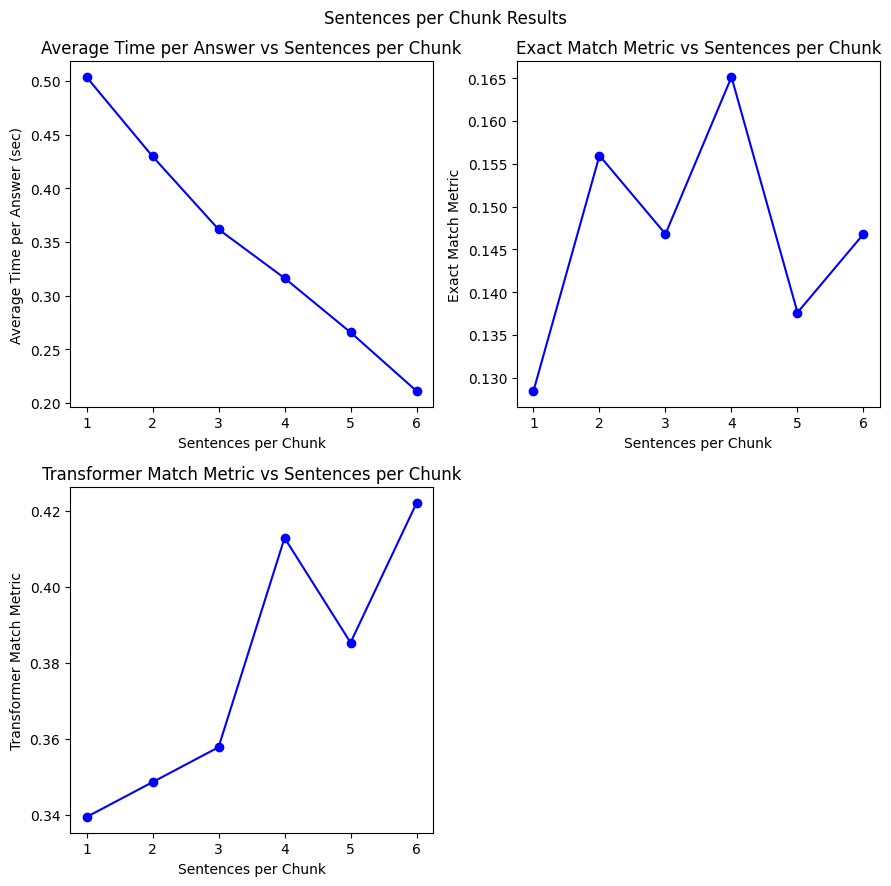

In [4]:
# Get stats lists
spcs = [int(s) for s in spc_stats.keys()]
times = [np.mean(stat['times']) for stat in spc_stats.values()]
tms = [np.mean(stat['tms']) for stat in spc_stats.values()]
ems = [np.mean(stat['ems']) for stat in spc_stats.values()]

# Create figure object with subplots
fig = plt.figure(figsize=(9,9))
spec = mpl.gridspec.GridSpec(ncols=2, nrows=2)

# Plot Times
ax = fig.add_subplot(spec[0, 0])
ax.plot(spcs, times,'bo-')
ax.set_title('Average Time per Answer vs Sentences per Chunk')
ax.set_xlabel('Sentences per Chunk')
ax.set_ylabel('Average Time per Answer (sec)')

# Plot exact match metrics
ax = fig.add_subplot(spec[0, 1])
ax.plot(spcs, ems,'bo-')
ax.set_title('Exact Match Metric vs Sentences per Chunk')
ax.set_xlabel('Sentences per Chunk')
ax.set_ylabel('Exact Match Metric')

# Plot transformer match metrics
ax = fig.add_subplot(spec[1, 0])
ax.plot(spcs, tms,'bo-')
ax.set_title('Transformer Match Metric vs Sentences per Chunk')
ax.set_xlabel('Sentences per Chunk')
ax.set_ylabel('Transformer Match Metric')

# Format figure
fig.suptitle("Sentences per Chunk Results")
fig.tight_layout()
plt.show()

### 2. [Generator Service] Generator Model Selection
The second analysis is to determine the effect of different question answering models on the quality and efficiency of the answers. BERT Large, BERT Base, and a BERT Large version fine tuned for question answering are used to generate answers to the validation set of questions, and the exact match, transformer match, and time to generate answers are tracked. The results below indicate that the BERT Large fine-tuned version results in the best answers based on the transformer match and exact match metrics; however, it also takes the second longest amount of time to generate an answer with an average of about 0.18 seconds per answer. Although the BERT Base model was about 3 times faster, the transformer and exact metrics were over 3 times worse. Ultimately, since 0.18 seconds is a reasonable response time for a human using a chatbot, I chose to use the best performing model, BERT Large fine-tuned, for deployment to the system.

First, generate and evaluate answers to all of the questions using all 3 models:

In [5]:
# Define consistent k
k = 3

# Initialize 3 question answering models
qa_models = {
    'BERT-large': BERTQuestionAnswer('google-bert/bert-large-uncased'),
    'BERT-large-finetuned': BERTQuestionAnswer('google-bert/bert-large-cased-whole-word-masking-finetuned-squad'),
    'BERT-base': BERTQuestionAnswer('google-bert/bert-base-uncased'),
}

# Initilaize metrics class
metrics = Metrics_Automated()

# Use the embeddings from the pipeline associated with sentences_per_chunk = 6
pipeline = pipelines[5]

# Initialize empty stats
qa_model_stats = {kk:{'times':[], 'ems':[], 'tms':[]} for kk in qa_models.keys()}

# Generate and evaluate answer for each question using the 3 QA models
for _, q in questions.iterrows():
    # Find most relevant context documents in corpus
    neighbors = pipeline.search_context(q['Question'], k)
    context = [n[1]['sentences'] for n in neighbors]
    # For each model, get an answer and evaluate it
    for name,v in qa_models.items():
        start = time.time()
        answer = v.get_answer(q['Question'], context)
        end = time.time()
        qa_model_stats.get(name).get('times').append(end-start)
        # Evaluate answer
        em = metrics.exact_match(answer, q['Answer'])
        qa_model_stats.get(name).get('ems').append(em)
        _ , tm = metrics.transformer_match(answer, q['Answer'], q['Question'])
        qa_model_stats.get(name).get('tms').append(tm)

/Users/riley/repos/karp-riley/.venv/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Using device: cpu


Finally, plot the exact match, transformer match, and time metrics for each question answering model.

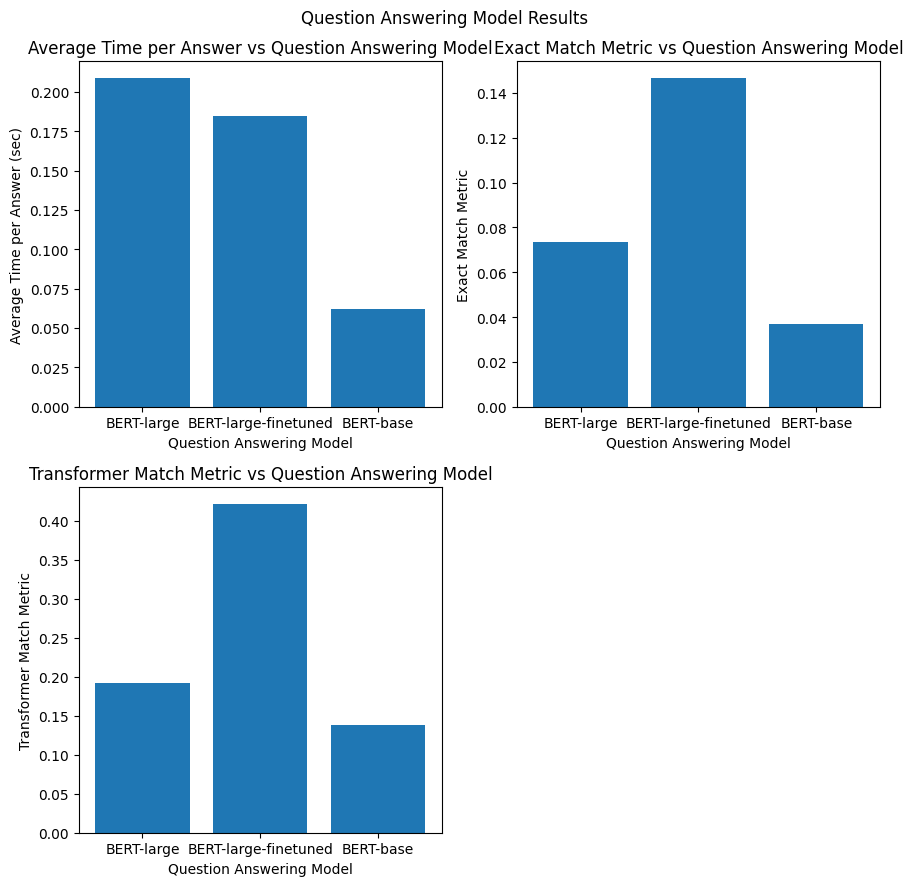

In [6]:
# Get stats lists
model_names = qa_model_stats.keys()
times = [np.mean(stat['times']) for stat in qa_model_stats.values()]
tms = [np.mean(stat['tms']) for stat in qa_model_stats.values()]
ems = [np.mean(stat['ems']) for stat in qa_model_stats.values()]

# Create figure object with subplots
fig = plt.figure(figsize=(9,9))
spec = mpl.gridspec.GridSpec(ncols=2, nrows=2)

# Plot times
ax = fig.add_subplot(spec[0, 0])
ax.bar(model_names, times)
ax.set_title('Average Time per Answer vs Question Answering Model')
ax.set_xlabel('Question Answering Model')
ax.set_ylabel('Average Time per Answer (sec)')

# Plot exact match metrics
ax = fig.add_subplot(spec[0, 1])
ax.bar(model_names, ems)
ax.set_title('Exact Match Metric vs Question Answering Model')
ax.set_xlabel('Question Answering Model')
ax.set_ylabel('Exact Match Metric')

# Plot transformer match metrics
ax = fig.add_subplot(spec[1, 0])
ax.bar(model_names, tms)
ax.set_title('Transformer Match Metric vs Question Answering Model')
ax.set_xlabel('Question Answering Model')
ax.set_ylabel('Transformer Match Metric')

# Format figure
fig.suptitle("Question Answering Model Results")
fig.tight_layout()
plt.show()

## Additional Analysis
Analysis beyond the minimum two required analyses.

### 3. [Retrieval Service] Number of Nearest Neighbors (K)
The next analysis is for determining the best number of nearest neighbors (k value) to use in the KNN search service used for retrieving the most relevant context chunks for a given question. The k values explored were [1, 2, 3, 4, 5, 10, 20, 25]. I went up to 25 because a common rule of thumb is to choose k equal to the square root of the number of "training" samples [Ref 6]. For our corpus, using sentences_per_chunk = 6 results in 512 total document chunks, and sqrt(512) is about 23, so I rounded it to 25 for my experiment. The `all-mpnet-base-v2` embedding model, BERT Large Fine-tuned question answering model, sentences per chunk = 6, and Euclidean similarity measure were used for this analysis. To measure the quality and efficiency of answer generation results for each value of k, the average time per question to get context and generate an answer were tracked, and the exact and transformer match metrics were calculated using the generated answer and ground truth answer.

The results below indicate that the average time per question generally increases as k increases, with more increase between k=1 to k=5, and then a more gradual increase for larger k, especially from k=20 to k=25. The exact match and transformer match metrics both increase with k between k=1 to k=3, but then decrease at k=4, increasing again to a maximum value at k=10 before decreasing for k > 10. Since the exact match and transformer match metrics are maximum at k=10 and with reasonable efficiency, then this led to the use of k=10 for the nearest neighbors value deployed to the system.

In [10]:
ks = [1, 2, 3, 4, 5, 10, 20, 25]

# Intiialize question answering model
qa_model = BERTQuestionAnswer('google-bert/bert-large-cased-whole-word-masking-finetuned-squad')

# Initilaize metrics class
metrics = Metrics_Automated()

# Use the embeddings from the pipeline associated with sentences_per_chunk = 6
pipeline = pipelines[5]

# Initialize empty stats
k_stats = {kval:{'times':[], 'ems':[], 'tms':[]} for kval in ks}

# Generate and evaluate answer for each question using the k values
for _, q in questions.iterrows():
    # For each k value, get context and an answer and evaluate it
    for k in ks:
        start = time.time()
        # Find most relevant context documents in corpus
        neighbors = pipeline.search_context(q['Question'], k)
        context = [n[1]['sentences'] for n in neighbors]
        # Get answer to the question using context
        answer = qa_model.get_answer(q['Question'], context)
        end = time.time()
        k_stats.get(k).get('times').append(end-start)
        # Evaluate answer
        em = metrics.exact_match(answer, q['Answer'])
        k_stats.get(k).get('ems').append(em)
        _ , tm = metrics.transformer_match(answer, q['Answer'], q['Question'])
        k_stats.get(k).get('tms').append(tm)

Using device: cpu


Finally, plot the exact match, transformer match, and time metrics vs. sentences per chunk.

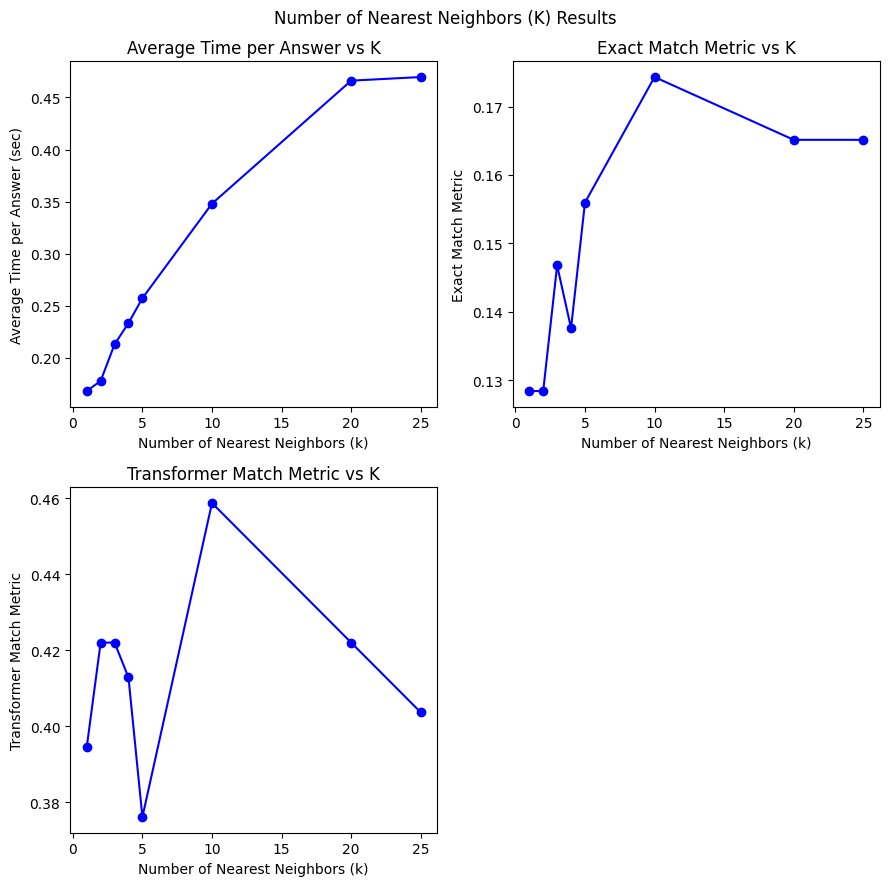

In [11]:
# Get stats lists
ks = [int(kval) for kval in k_stats.keys()]
times = [np.mean(stat['times']) for stat in k_stats.values()]
tms = [np.mean(stat['tms']) for stat in k_stats.values()]
ems = [np.mean(stat['ems']) for stat in k_stats.values()]

# Create figure object with subplots
fig = plt.figure(figsize=(9,9))
spec = mpl.gridspec.GridSpec(ncols=2, nrows=2)

# Plot Times
ax = fig.add_subplot(spec[0, 0])
ax.plot(ks, times,'bo-')
ax.set_title('Average Time per Answer vs K')
ax.set_xlabel('Number of Nearest Neighbors (k)')
ax.set_ylabel('Average Time per Answer (sec)')

# Plot exact match metrics
ax = fig.add_subplot(spec[0, 1])
ax.plot(ks, ems,'bo-')
ax.set_title('Exact Match Metric vs K')
ax.set_xlabel('Number of Nearest Neighbors (k)')
ax.set_ylabel('Exact Match Metric')

# Plot transformer match metrics
ax = fig.add_subplot(spec[1, 0])
ax.plot(ks, tms,'bo-')
ax.set_title('Transformer Match Metric vs K')
ax.set_xlabel('Number of Nearest Neighbors (k)')
ax.set_ylabel('Transformer Match Metric')

# Format figure
fig.suptitle("Number of Nearest Neighbors (K) Results")
fig.tight_layout()
plt.show()